# Email Spam classifier

In [453]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [455]:
df = pd.read_csv(r'C:\Users\win10\Downloads\spam email\CEAS_08.csv')

In [456]:
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [457]:
df.shape

(39154, 7)

In [458]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


In [459]:
df.isnull().sum()

sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64

In [460]:
df.duplicated().sum()

0

In [461]:
# very less number of rows are empty so removing them all.

df.dropna(inplace = True)

In [462]:
df.isnull().sum()

sender      0
receiver    0
date        0
subject     0
body        0
label       0
urls        0
dtype: int64

In [463]:
df.shape

(38669, 7)

In [464]:
# coverting Young Esposito <Young@iworld.de>  to  iworld.de

df['sender'] = df['sender'].apply(lambda x:x.split('@')[-1].replace('>',''))
df['receiver'] = df['receiver'].apply(lambda x:x.split('@')[-1].replace('>',''))

In [465]:
df.head(2)

,sender,receiver,date,subject,body,label,urls
0,iworld.de,gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,icable.ph,gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1


<Axes: ylabel='sender'>

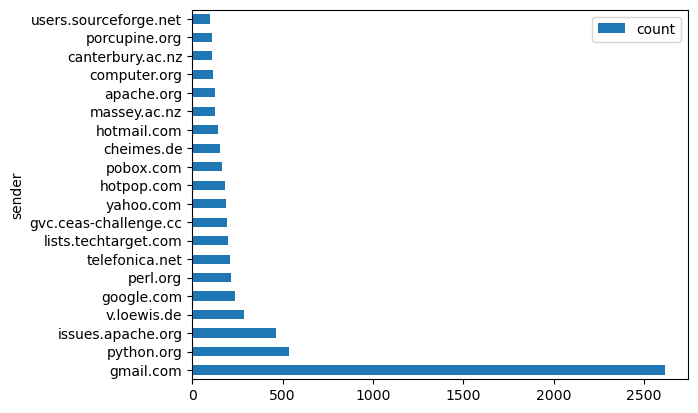

In [466]:
sender_data = df['sender'].value_counts().reset_index()[:20]
sender_data.plot.barh('sender','count')

### Observation : Most of the emails are sent from Gmail

<Axes: ylabel='receiver'>

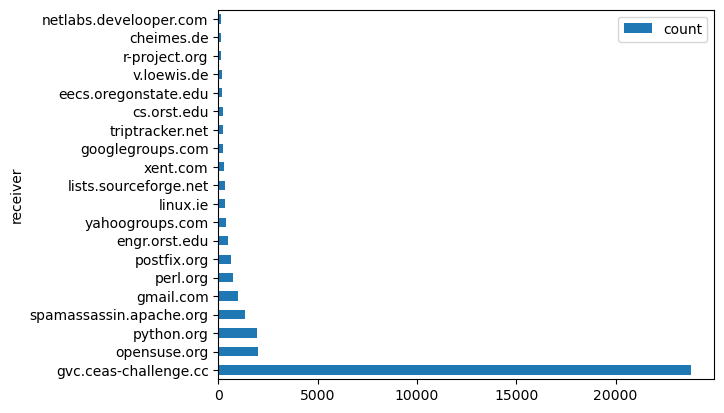

In [468]:
sender_data = df['receiver'].value_counts().reset_index()[:20]
sender_data.plot.barh('receiver','count')

### Observation : Most of the emails are received on "gvc.ceas-challenge.cc" domain

In [470]:
label_count = df['label'].value_counts()
label_count 

label
1    21827
0    16842
Name: count, dtype: int64

In [603]:
print('Spam : ',label_count[1]*100/len(df),"%")
print('Not Spam : ',label_count[0]*100/len(df),"%")

Spam :  56.44573172308568 %
Not Spam :  43.55426827691432 %


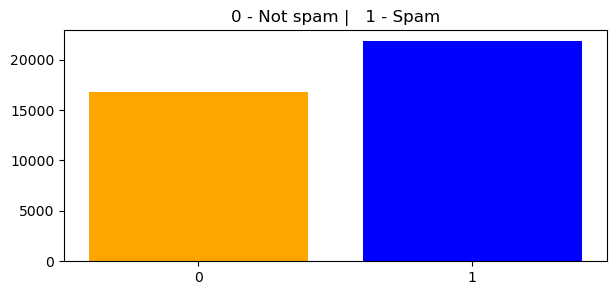

In [471]:
plt.figure(figsize=(7,3))
plt.bar(x = label_count.index ,height=label_count.values,color=['blue', 'orange'])
plt.xticks((0,1))
plt.title('0 - Not spam |   1 - Spam')
plt.show()

### Dataset is imbalanced

urls
1    25994
0    12675
Name: count, dtype: int64


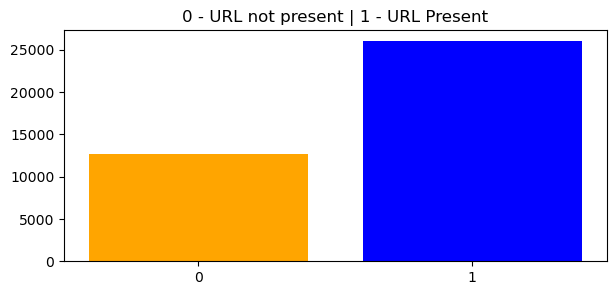

In [473]:
plt.figure(figsize=(7,3))
count = df['urls'].value_counts()
print(count)
plt.bar(x = count.index ,height=count.values,color=['blue', 'orange'])
plt.xticks((0,1))
plt.title('0 - URL not present | 1 - URL Present')
plt.show()

### Most of the emails have URLs.

In [475]:
spam_url=df[df['label']==1]['urls'].reset_index(drop=True).value_counts()
notspam_url = df[df['label']==0]['urls'].reset_index(drop=True).value_counts()


print('spam with/without URLs',spam_url)
print('---------------------------------------')
print('Not Spam with/without URLs',notspam_url)


spam with/without URLs urls
1    14887
0     6940
Name: count, dtype: int64
---------------------------------------
Not Spam with/without URLs urls
1    11107
0     5735
Name: count, dtype: int64


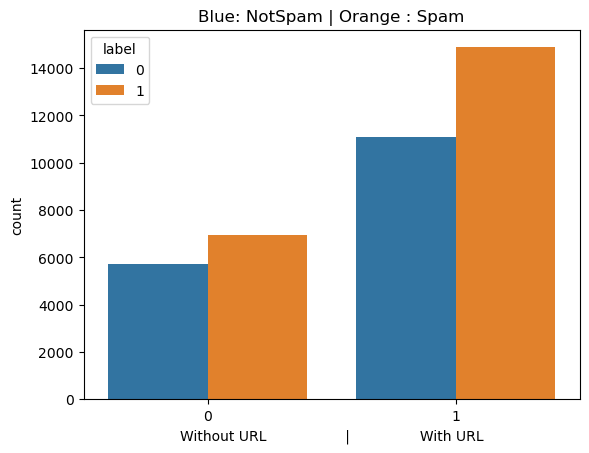

In [476]:
sns.countplot(data=df, x='urls',hue='label')
plt.xlabel('Without URL                  |                With URL')
plt.title('Blue: NotSpam | Orange : Spam')
plt.show()

### There is no clear extinction between the emails with or without URLs and whether email is spam or not

In [478]:
df['dayOfWeek'] = df['date'].apply(lambda x:x[:3])
df['dayOfWeek'] 

0        Tue
1        Tue
2        Tue
3        Tue
4        Tue
        ... 
39149    Fri
39150    Fri
39151    Fri
39152    Fri
39153    Fri
Name: dayOfWeek, Length: 38669, dtype: object

In [479]:
df['date'] = pd.to_datetime(df['date'],errors= 'coerce',utc = True)
df['date']

0       2008-08-05 23:31:02+00:00
1       2008-08-05 23:31:03+00:00
2       2008-08-06 08:28:00+00:00
3       2008-08-05 23:31:20+00:00
4       2008-08-05 23:31:21+00:00
                   ...           
39149   2008-08-08 14:34:50+00:00
39150   2008-08-08 14:35:11+00:00
39151   2008-08-08 14:00:43+00:00
39152   2008-08-08 14:00:46+00:00
39153   2008-08-08 14:00:18+00:00
Name: date, Length: 38669, dtype: datetime64[ns, UTC]

In [480]:
df['date'].info()

<class 'pandas.core.series.Series'>
Index: 38669 entries, 0 to 39153
Series name: date
Non-Null Count  Dtype              
--------------  -----              
38654 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 604.2 KB


In [481]:
df.reset_index(inplace = True,drop=True)  # resetting index as few dates are changed to NAN

df['date'].isnull().sum()

15

In [482]:
df[df['date'].isnull()]

,sender,receiver,date,subject,body,label,urls,dayOfWeek
6224,bodyandcolor.com,gvc.ceas-challenge.cc,NaT,All that beach chicks,Summer is here \n\nhttp://lookresolution.com/?...,1,1,Tue
7343,blumhorst.com,gvc.ceas-challenge.cc,NaT,Need no words,Need no words \n\nhttp://spivaka.cn/v/\n\n\n,1,1,Wed
8528,boxerproperty.com,gvc.ceas-challenge.cc,NaT,Sunshine,Olympus mountain \n\nhttp://eitherindependence...,1,1,Wed
9502,boltongrp.com,gvc.ceas-challenge.cc,NaT,Beijing 2008,Olympic people \n\nhttp://eitherindependence.c...,1,1,Wed
12114,bosaship.com,gvc.ceas-challenge.cc,NaT,Get hot,"Sun, sea and summer \n\nhttp://eitherindepende...",1,1,Wed
13690,bol3.com,gvc.ceas-challenge.cc,NaT,Olympic strength,Summer is here \n\nhttp://definitioneven.com/?...,1,1,Wed
15928,bradenbenefits.com,gvc.ceas-challenge.cc,NaT,As simple as black and white,Wonderful thing \n\nhttp://bunjax.cn/a/\n\n\n,1,1,Thu
17380,qq.com,gvc.ceas-challenge.cc,NaT,Feel younger,Whatever \n\nhttp://runlyr.cn/v/\n\n\n,1,1,Wed
18300,mail.china.com,gvc.ceas-challenge.cc,NaT,Great power,Olympus mountain \n\nhttp://definitioneven.com...,1,1,Thu
19220,icqmail.com,gvc.ceas-challenge.cc,NaT,Have a secret?,\nHave a secret? \n\nhttp://nakseh.cn/a/\n\n\n,1,1,Thu


In [483]:
df['date'] = df['date'].fillna(method='ffill') #forward filling dates

df['date'].isnull().sum()

C:\Users\win10\AppData\Local\Temp\ipykernel_2844\3504889436.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['date'] = df['date'].fillna(method='ffill') #forward filling dates


0

In [484]:
df['date'].dt.year.value_counts()

date
2008    38477
2007       37
2002       33
2000       25
2005       18
2003       16
2009       15
2001       13
2004       10
2006        7
2100        4
2020        2
1998        2
1986        2
2080        1
2031        1
2012        1
1981        1
2010        1
2086        1
1980        1
1999        1
Name: count, dtype: int64

### Most of the data is from the year 2008.

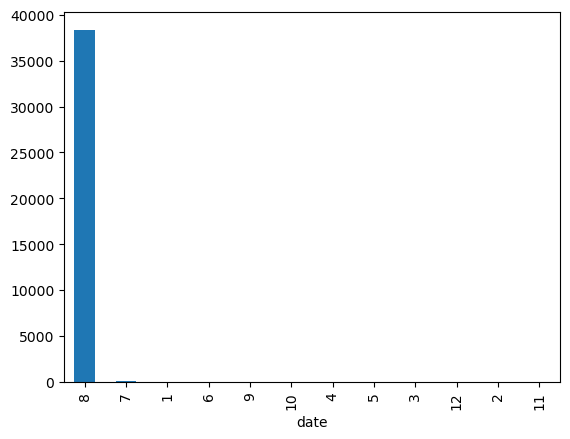

In [486]:
month_count = df['date'].dt.month.value_counts()
month_count.plot.bar()
plt.show()

### Above graph resrents that a big chunk of data belongs to Aug'2008 

In [488]:
df['dayOfWeek'].value_counts()

dayOfWeek
Wed    14111
Thu    12684
Fri     6857
Tue     4629
Mon      210
Sat      103
Sun       75
Name: count, dtype: int64

<Axes: xlabel='dayOfWeek', ylabel='count'>

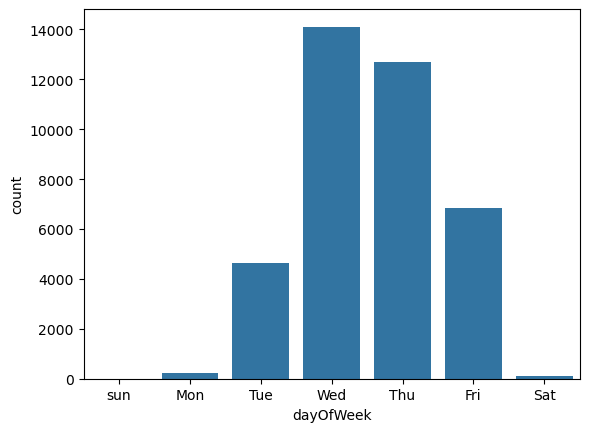

In [489]:
sns.countplot(data = df, x ='dayOfWeek',order = ['sun','Mon','Tue','Wed','Thu','Fri','Sat'])

### Most of emails are sent on Wed & Thu

In [491]:
df.head(2)

,sender,receiver,date,subject,body,label,urls,dayOfWeek
0,iworld.de,gvc.ceas-challenge.cc,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Tue
1,icable.ph,gvc.ceas-challenge.cc,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Tue


Text(0, 0.5, 'Number of emails')

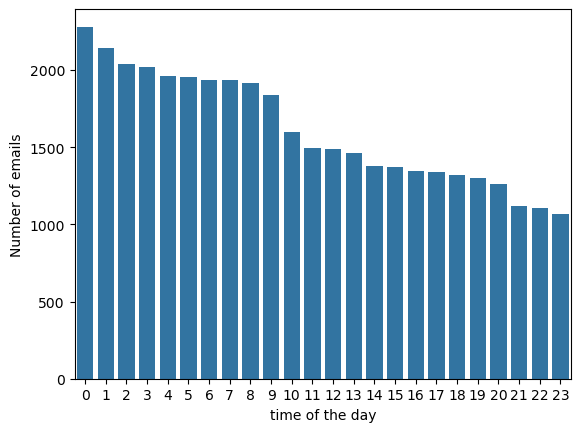

In [492]:
time = df['date'].dt.hour.value_counts().reset_index(drop=True)

sns.barplot(x = time.index, y = time.values)
plt.xlabel('time of the day')
plt.ylabel('Number of emails')

### Most of the emails are sent from midight to 09 AM and as the day progresses, the number of emails decline.

<Axes: xlabel='date', ylabel='count'>

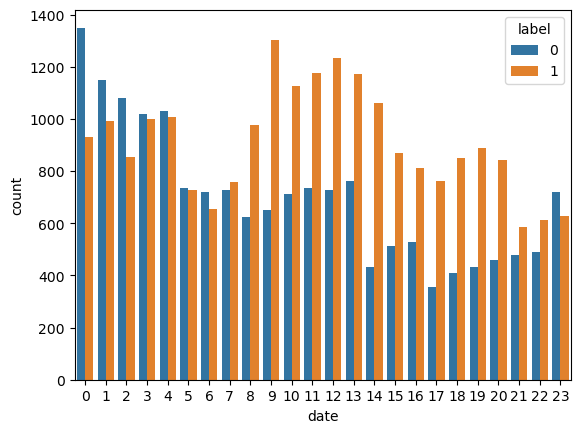

In [494]:
sns.countplot(data = df, x = df.date.dt.hour, hue =df.label)

### The number of spam emails are more than non-spam emails from 08 AM to 08 PM

In [496]:
df.head(2)

,sender,receiver,date,subject,body,label,urls,dayOfWeek
0,iworld.de,gvc.ceas-challenge.cc,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Tue
1,icable.ph,gvc.ceas-challenge.cc,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Tue


In [497]:
print('Unique sender email addresses : ',len(df['sender'].unique()))
print('Unique receiver email addresses : ',len(df['receiver'].unique()))

Unique sender email addresses :  17703
Unique receiver email addresses :  929


In [498]:
top20_sender = df['sender'].value_counts().nlargest(20).index  # encoding top 20 and rest other 
top20_receiver = df['receiver'].value_counts().nlargest(20).index  


df['sender_encoded'] = df['sender'].apply(lambda x:x if x in top20_sender else 'other')
df['receiver_encoded'] = df['receiver'].apply(lambda x:x if x in top20_receiver else 'other')

In [499]:
le = LabelEncoder()
df['sender_encoded'] = le.fit_transform(df['sender_encoded'])
df['receiver_encoded'] = le.fit_transform(df['receiver_encoded'])
df['dayOfWeek'] = le.fit_transform(df['dayOfWeek'])

In [500]:
df.head(4)

,sender,receiver,date,subject,body,label,urls,dayOfWeek,sender_encoded,receiver_encoded
0,iworld.de,gvc.ceas-challenge.cc,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,5,12,6
1,icable.ph,gvc.ceas-challenge.cc,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,5,12,6
2,universalnet.psi.br,gvc.ceas-challenge.cc,2008-08-06 08:28:00+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,5,12,6
3,pobox.com,spamassassin.apache.org,2008-08-05 23:31:20+00:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,5,14,16


In [501]:
ps = PorterStemmer()

def stemming(text):
    lst = []
    text = re.sub(r'[^a-zA-Z0-9 ]'," ",text)
    for i in text.split():
        lst.append(ps.stem(i))
    return " ".join(lst)    


    

In [502]:
df['subject'] = df['subject'].apply(stemming)

df['subject']

0                                 never agre to be a loser
1                                   befriend jenna jameson
2                                     cnn com daili top 10
3        re svn commit r619753 in spamassassin trunk li...
4                               specialpricespharmmoreinfo
                               ...                        
38664                            cnn alert my custom alert
38665                            cnn alert my custom alert
38666                                     slideshow viewer
38667                                 note on 2 digit year
38668                           python dev pep 370 head up
Name: subject, Length: 38669, dtype: object

In [503]:
df['body'] = df['body'].apply(stemming)

df['body']

0        buck up your troubl caus by small dimens will ...
1        upgrad your sex and pleasur with these techniq...
2        the daili top 10 from cnn com top video and st...
3        would anyon object to remov so from thi list t...
4        welcomefastshippingcustomersupport http 7iwfna...
                               ...                        
38664    cnn alert my custom alert alert name my custom...
38665    cnn alert my custom alert alert name my custom...
38666    hello there great work on the slide show viewe...
38667    mail from sender come from intuit com server 2...
38668    dear fellow pythonista guido ha accept my user...
Name: body, Length: 38669, dtype: object

In [504]:
df.head(3)

,sender,receiver,date,subject,body,label,urls,dayOfWeek,sender_encoded,receiver_encoded
0,iworld.de,gvc.ceas-challenge.cc,2008-08-05 23:31:02+00:00,never agre to be a loser,buck up your troubl caus by small dimens will ...,1,1,5,12,6
1,icable.ph,gvc.ceas-challenge.cc,2008-08-05 23:31:03+00:00,befriend jenna jameson,upgrad your sex and pleasur with these techniq...,1,1,5,12,6
2,universalnet.psi.br,gvc.ceas-challenge.cc,2008-08-06 08:28:00+00:00,cnn com daili top 10,the daili top 10 from cnn com top video and st...,1,1,5,12,6


In [505]:
df['text'] = df['subject']+" "+ df['body']

In [506]:
x = df['text']
y = df['label']

In [507]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify= y, random_state=42)

In [508]:
print(x_train.shape)
print(y_train.shape)

(25908,)
(25908,)


In [509]:
tfidf = TfidfVectorizer(max_features = 2400, stop_words = 'english')


x_train = tfidf.fit_transform(x_train).toarray()
x_test = tfidf.transform(x_test).toarray()



In [510]:

tfidf1.get_feature_names_out()[:500]



array(['07may2008', '0nline', '0ver', '10', '100', '100mg', '102', '103',
       '103rephras', '107', '11', '110', '12', '123', '13', '14', '140',
       '15', '16', '19', '199', '20', '200', '2005', '2006', '2007',
       '2008', '23', '24', '25', '256bit', '26', '26a1', '29', '2nd',
       '2to3', '30', '3000', '30a3', '3108', '32bit', '36', '365', '3945',
       '3oo', '46011', '47181', '50', '50mg', '510', '5100', '5817',
       '588', '60', '64bit', '65', '72', '90', '999', 'abridg', 'abus',
       'accept', 'access', 'accessori', 'account', 'acm', 'act', 'action',
       'activ', 'ad', 'add', 'address', 'admir', 'advertis', 'advic',
       'adword', 'afford', 'afraid', 'age', 'agent', 'agm', 'ai', 'alert',
       'alia', 'allow', 'alpha', 'alreadi', 'altern', 'alway', 'amavisd',
       'amazoncom', 'analysi', 'angri', 'ani', 'ann', 'announc', 'anoth',
       'answer', 'antispam', 'anymor', 'anyon', 'apach', 'api', 'applic',
       'appreci', 'approach', 'approv', 'april', 'articl

In [512]:
# new_x_train  = x_train[['sender_encoded','receiver_encoded','urls','dayOfWeek']].reset_index(drop=True)

# x_train = pd.concat([x_train_sub,x_train_body,new_x_train],axis = 1,ignore_index=True)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# new_x_test  = x_test[['sender_encoded','receiver_encoded','urls','dayOfWeek']].reset_index(drop=True)

# x_test = pd.concat([x_test_sub,x_test_body,new_x_test],axis = 1,ignore_index=True)

In [540]:
print(x_train.shape)
print(x_test.shape)

(25908, 2400)
(12761, 2400)


## Model Building

In [543]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB

In [545]:
clf1 = MultinomialNB()

clf1.fit(x_train,y_train)

train_pred = clf1.predict(x_train)

test_pred = clf1.predict(x_test)


In [546]:
from sklearn.metrics import classification_report, accuracy_score, precision_score

In [549]:
print(confusion_matrix(y_train,train_pred))

[[11169   115]
 [  563 14061]]


In [551]:
print(confusion_matrix(y_test,test_pred))

[[5503   55]
 [ 298 6905]]


In [553]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     11284
           1       0.99      0.96      0.98     14624

    accuracy                           0.97     25908
   macro avg       0.97      0.98      0.97     25908
weighted avg       0.97      0.97      0.97     25908



In [555]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5558
           1       0.99      0.96      0.98      7203

    accuracy                           0.97     12761
   macro avg       0.97      0.97      0.97     12761
weighted avg       0.97      0.97      0.97     12761



In [557]:
clf2 = GaussianNB()

clf2.fit(x_train,y_train)

train_pred = clf2.predict(x_train)

test_pred = clf2.predict(x_test)


In [558]:
print(confusion_matrix(y_train,train_pred))

[[11141   143]
 [  210 14414]]


In [559]:
print(confusion_matrix(y_test,test_pred))

[[5493   65]
 [ 166 7037]]


In [560]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5558
           1       0.99      0.98      0.98      7203

    accuracy                           0.98     12761
   macro avg       0.98      0.98      0.98     12761
weighted avg       0.98      0.98      0.98     12761



In [561]:
clf3 = BernoulliNB()

clf3.fit(x_train,y_train)

train_pred = clf3.predict(x_train)

test_pred = clf3.predict(x_test)


In [562]:
print(confusion_matrix(y_test,test_pred))

[[5328  230]
 [ 141 7062]]


In [563]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      5558
           1       0.97      0.98      0.97      7203

    accuracy                           0.97     12761
   macro avg       0.97      0.97      0.97     12761
weighted avg       0.97      0.97      0.97     12761



In [564]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [565]:
svc = SVC(kernel='sigmoid')
knn = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5,random_state=24)
rfc = RandomForestClassifier(n_estimators=50, random_state=24)
gbc = GradientBoostingClassifier(n_estimators=50,random_state=24)
xgb = XGBClassifier(n_estimators=50,random_state=24)

In [566]:
algo = {'svc':svc,
        'knn':knn,
        'mnb':mnb,
        'dtc':dtc,
        'rfc':rfc,
        'gbc':gbc,
        'xgb':xgb}

In [567]:
def train_classifier(clf, x_train,x_test,y_train,y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    acc  = accuracy_score(y_test,y_pred)
    pre = precision_score(y_test,y_pred)
    return acc,pre

In [568]:
accuracy = []
precision = []

for alg in algo.values():
    acc,pre = train_classifier(alg, x_train,x_test,y_train,y_test)
    accuracy.append(acc)
    precision.append(pre)
    
    

In [569]:
accuracy

[0.9916150771883081,
 0.851500666091999,
 0.9723375910978763,
 0.9392680824386803,
 0.9933390800094036,
 0.9697515868662331,
 0.9914583496591176]

In [570]:
performance = pd.DataFrame({'Algo':algo.keys(),'Accuracy' :accuracy,'Precision':precision}).sort_values('Precision',ascending = False)

In [571]:
performance

,Algo,Accuracy,Precision
4,rfc,0.993339,0.994855
2,mnb,0.972338,0.992098
0,svc,0.991615,0.991821
6,xgb,0.991458,0.989917
5,gbc,0.969752,0.958563
3,dtc,0.939268,0.911629
1,knn,0.851501,0.791969


In [587]:
# showing depth of all 50 estimator of Random forest
for i in rfc.estimators_:
    print(i.get_depth())


209
200
196
203
213
240
223
208
202
227
213
122
211
175
197
122
237
206
230
213
211
243
202
206
207
212
247
159
157
236
140
225
213
122
214
120
89
116
252
121
135
215
229
145
208
127
215
187
212
211


In [589]:
import pickle

In [595]:
pickle.dump(stemming,open('stemming.pkl','wb'))
pickle.dump(tfidf,open('tfidf.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))

In [593]:
pip install Pandoc

Note: you may need to restart the kernel to use updated packages.Collecting Pandoc
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/128.0 kB ? eta -:--:--
   ---------------------------- ----------- 92.2/128.0 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 128.0/128.0 kB 1.9 MB/s eta 0:00:00
  Created wheel for Pandoc: filename=pandoc-2.4-py3-none-any.whl size=34823 sha256=6e7a3fe25d6b9270d54ec33139f6fd630d1e317a94f90799e95116f23827e816
  Stored in directory: c:\users\win10\appdata\local\pip\cache\wheels\9c\2f\9f\b1aac8c3e74b4ee327dc8c6eac5128996f9eadf586e2c0ba67
Successfully built Pandoc

